In [1]:
import matplotlib

In [2]:
import os
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader

# datapath = os.path.join('..', 'data')
# filterpath = os.path.join(datapath, 'filters-complete', '8_19')
datapath = os.path.join('../', 'data')
filterpath = os.path.join(datapath, '8_19')
num_filters = 8
savepath = 'vae_joint_' + str(num_filters) + '.pt'

In [3]:
def get_joint_dataset():
  weight_dataset = []
  for f, file in tqdm(enumerate(os.listdir(filterpath))):
    filter = torch.load(os.path.join(filterpath, file))
    weight_dataset.append(filter['0.weight'])
  return torch.stack(weight_dataset)

num_images = len(os.listdir(filterpath))
dataset = get_joint_dataset()

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

1364it [00:02, 513.99it/s] 


In [4]:
dataset.shape

torch.Size([1364, 8, 1, 5, 5])

In [5]:
vae_batch_size = 100

x_dim  = 25*num_filters
hidden_dim1 = 20*num_filters
hidden_dim2 = 20*num_filters
hidden_dim3 = 20*num_filters
hidden_dim4 = 20*num_filters
latent_dim = 10*num_filters

kl_start = 0
warm_up = 50000

lr = 1e-2

epochs = 500

# kwargs = {'num_workers': 1} 

train_dataset = dataset.to(device)
train_loader = DataLoader(dataset=train_dataset, batch_size=vae_batch_size, shuffle=True)

In [6]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim1)
        self.FC_input2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.FC_input3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.FC_input4 = nn.Linear(hidden_dim3, hidden_dim4)

        self.FC_mean  = nn.Linear(hidden_dim2, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim2, latent_dim)
        
        # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()

        self.training = True
        
    def forward(self, x):
        h_       = self.tanh(self.FC_input(x))
        h_       = self.tanh(self.FC_input2(h_))
        h_       = self.tanh(self.FC_input3(h_))
        h_       = self.tanh(self.FC_input4(h_))

        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim1)
        self.FC_hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.FC_hidden3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.FC_hidden4 = nn.Linear(hidden_dim3, hidden_dim4)

        self.FC_output = nn.Linear(hidden_dim4, output_dim)
        
        # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        h     = self.tanh(self.FC_hidden(x))
        h     = self.tanh(self.FC_hidden2(h))
        h     = self.tanh(self.FC_hidden3(h))
        h     = self.tanh(self.FC_hidden4(h))

        x_hat = self.FC_output(h)
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        # self.lamb = nn.Parameter(data=torch.Tensor(1), requires_grad=True)
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

encoder = Encoder(input_dim=x_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, hidden_dim3=hidden_dim3, hidden_dim4=hidden_dim4, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, hidden_dim3=hidden_dim3, hidden_dim4=hidden_dim4, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)
criterion = torch.nn.MSELoss()

In [7]:
kl_weight = kl_start
anneal_rate = (1.0 - kl_start) / (warm_up * (len(train_dataset) / vae_batch_size))

In [8]:
optimizer = Adam(model.parameters(), lr=lr)

model.train()

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=200, out_features=160, bias=True)
    (FC_input2): Linear(in_features=160, out_features=160, bias=True)
    (FC_input3): Linear(in_features=160, out_features=160, bias=True)
    (FC_input4): Linear(in_features=160, out_features=160, bias=True)
    (FC_mean): Linear(in_features=160, out_features=80, bias=True)
    (FC_var): Linear(in_features=160, out_features=80, bias=True)
    (tanh): Tanh()
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=80, out_features=160, bias=True)
    (FC_hidden2): Linear(in_features=160, out_features=160, bias=True)
    (FC_hidden3): Linear(in_features=160, out_features=160, bias=True)
    (FC_hidden4): Linear(in_features=160, out_features=160, bias=True)
    (FC_output): Linear(in_features=160, out_features=200, bias=True)
    (tanh): Tanh()
  )
)

In [9]:
reproduction_losses = []
for epoch in range(epochs):
    overall_loss = 0
    reproduction_loss_epoch = 0
    KL_loss_epoch = 0
    for batch_idx, x in enumerate(train_loader):

        model.train()
        x = x.view(x.shape[0], x_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        
        kl_weight = min(1.0, kl_weight + anneal_rate)

        reproduction_loss = torch.mean(torch.norm(x_hat - x, dim=1) ** 2)
        KL_loss      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
        loss_val = reproduction_loss + kl_weight * KL_loss
        
        overall_loss += loss_val.item()
        reproduction_loss_epoch += reproduction_loss.item()
        KL_loss_epoch += KL_loss.item()
        
        loss_val.backward()
        optimizer.step()

    reproduction_losses.append(reproduction_loss_epoch/(batch_idx*vae_batch_size))
    # print(model.Encoder.FC_mean.grad) 
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", round(overall_loss / (batch_idx*vae_batch_size), 6), 'Reproduction loss', round(reproduction_loss_epoch/ (batch_idx*vae_batch_size), 4), 'KL_loss', round(KL_loss_epoch/ (batch_idx*vae_batch_size), 7), 'kl weight', round(kl_weight, 2))
    
torch.save(model.state_dict(), os.path.join(datapath, savepath))

	Epoch 1 complete! 	Average Loss:  3.541152 Reproduction loss 3.5394 KL_loss 122.4537291 kl weight 0.0
	Epoch 2 complete! 	Average Loss:  2.572794 Reproduction loss 2.5643 KL_loss 265.0208909 kl weight 0.0
	Epoch 3 complete! 	Average Loss:  2.166841 Reproduction loss 2.1495 KL_loss 333.4178456 kl weight 0.0
	Epoch 4 complete! 	Average Loss:  1.919556 Reproduction loss 1.8932 KL_loss 363.517835 kl weight 0.0
	Epoch 5 complete! 	Average Loss:  1.787744 Reproduction loss 1.7487 KL_loss 419.0812034 kl weight 0.0
	Epoch 6 complete! 	Average Loss:  1.591185 Reproduction loss 1.5375 KL_loss 473.1405349 kl weight 0.0
	Epoch 7 complete! 	Average Loss:  1.419299 Reproduction loss 1.3556 KL_loss 475.586896 kl weight 0.0
	Epoch 8 complete! 	Average Loss:  1.418705 Reproduction loss 1.3477 KL_loss 459.4678215 kl weight 0.0
	Epoch 9 complete! 	Average Loss:  1.388485 Reproduction loss 1.3053 KL_loss 475.7980138 kl weight 0.0
	Epoch 10 complete! 	Average Loss:  1.304199 Reproduction loss 1.2196 KL_lo

	Epoch 82 complete! 	Average Loss:  0.890537 Reproduction loss 0.5909 KL_loss 179.0532888 kl weight 0.0
	Epoch 83 complete! 	Average Loss:  0.853635 Reproduction loss 0.5589 KL_loss 173.9888845 kl weight 0.0
	Epoch 84 complete! 	Average Loss:  0.86748 Reproduction loss 0.5701 KL_loss 173.4867751 kl weight 0.0
	Epoch 85 complete! 	Average Loss:  0.84178 Reproduction loss 0.5524 KL_loss 166.7563041 kl weight 0.0
	Epoch 86 complete! 	Average Loss:  0.834653 Reproduction loss 0.5494 KL_loss 162.4819343 kl weight 0.0
	Epoch 87 complete! 	Average Loss:  0.866919 Reproduction loss 0.5643 KL_loss 170.3448813 kl weight 0.0
	Epoch 88 complete! 	Average Loss:  0.91065 Reproduction loss 0.5951 KL_loss 175.6336644 kl weight 0.0
	Epoch 89 complete! 	Average Loss:  0.967461 Reproduction loss 0.6338 KL_loss 183.6044651 kl weight 0.0
	Epoch 90 complete! 	Average Loss:  0.95932 Reproduction loss 0.6134 KL_loss 188.2431873 kl weight 0.0
	Epoch 91 complete! 	Average Loss:  0.902142 Reproduction loss 0.574

	Epoch 162 complete! 	Average Loss:  0.903885 Reproduction loss 0.5515 KL_loss 106.2736816 kl weight 0.0
	Epoch 163 complete! 	Average Loss:  0.922039 Reproduction loss 0.5857 KL_loss 100.803439 kl weight 0.0
	Epoch 164 complete! 	Average Loss:  0.879924 Reproduction loss 0.5388 KL_loss 101.6102036 kl weight 0.0
	Epoch 165 complete! 	Average Loss:  0.972255 Reproduction loss 0.6097 KL_loss 107.3248505 kl weight 0.0
	Epoch 166 complete! 	Average Loss:  1.047509 Reproduction loss 0.5693 KL_loss 140.7516816 kl weight 0.0
	Epoch 167 complete! 	Average Loss:  1.050278 Reproduction loss 0.5953 KL_loss 133.0746236 kl weight 0.0
	Epoch 168 complete! 	Average Loss:  1.101068 Reproduction loss 0.6106 KL_loss 142.6193254 kl weight 0.0
	Epoch 169 complete! 	Average Loss:  1.044155 Reproduction loss 0.6036 KL_loss 127.3570361 kl weight 0.0
	Epoch 170 complete! 	Average Loss:  0.927414 Reproduction loss 0.5461 KL_loss 109.5703902 kl weight 0.0
	Epoch 171 complete! 	Average Loss:  0.84694 Reproductio

	Epoch 242 complete! 	Average Loss:  1.177104 Reproduction loss 0.5835 KL_loss 119.7345035 kl weight 0.0
	Epoch 243 complete! 	Average Loss:  1.135521 Reproduction loss 0.5798 KL_loss 111.6392428 kl weight 0.0
	Epoch 244 complete! 	Average Loss:  1.07477 Reproduction loss 0.5725 KL_loss 100.4624977 kl weight 0.01
	Epoch 245 complete! 	Average Loss:  1.069023 Reproduction loss 0.5575 KL_loss 101.9007302 kl weight 0.01
	Epoch 246 complete! 	Average Loss:  0.981577 Reproduction loss 0.5417 KL_loss 87.2819385 kl weight 0.01
	Epoch 247 complete! 	Average Loss:  1.020692 Reproduction loss 0.6056 KL_loss 82.0228726 kl weight 0.01
	Epoch 248 complete! 	Average Loss:  1.123681 Reproduction loss 0.5886 KL_loss 105.2956663 kl weight 0.01
	Epoch 249 complete! 	Average Loss:  0.989199 Reproduction loss 0.5445 KL_loss 87.1642582 kl weight 0.01
	Epoch 250 complete! 	Average Loss:  0.959897 Reproduction loss 0.534 KL_loss 83.1325462 kl weight 0.01
	Epoch 251 complete! 	Average Loss:  1.026478 Reproduc

	Epoch 322 complete! 	Average Loss:  1.222078 Reproduction loss 0.6326 KL_loss 89.3145016 kl weight 0.01
	Epoch 323 complete! 	Average Loss:  1.13699 Reproduction loss 0.5853 KL_loss 83.3292398 kl weight 0.01
	Epoch 324 complete! 	Average Loss:  1.131929 Reproduction loss 0.5956 KL_loss 80.7566726 kl weight 0.01
	Epoch 325 complete! 	Average Loss:  1.201754 Reproduction loss 0.6049 KL_loss 89.5905153 kl weight 0.01
	Epoch 326 complete! 	Average Loss:  1.235655 Reproduction loss 0.5467 KL_loss 103.1021334 kl weight 0.01
	Epoch 327 complete! 	Average Loss:  1.076694 Reproduction loss 0.5319 KL_loss 81.2845204 kl weight 0.01
	Epoch 328 complete! 	Average Loss:  0.942283 Reproduction loss 0.5046 KL_loss 65.0948156 kl weight 0.01
	Epoch 329 complete! 	Average Loss:  0.911825 Reproduction loss 0.5057 KL_loss 60.2280097 kl weight 0.01
	Epoch 330 complete! 	Average Loss:  0.959317 Reproduction loss 0.5387 KL_loss 62.1726901 kl weight 0.01
	Epoch 331 complete! 	Average Loss:  1.220293 Reproduct

	Epoch 400 complete! 	Average Loss:  1.256193 Reproduction loss 0.6131 KL_loss 78.4148103 kl weight 0.01
	Epoch 401 complete! 	Average Loss:  1.11185 Reproduction loss 0.5733 KL_loss 65.5017822 kl weight 0.01
	Epoch 402 complete! 	Average Loss:  1.03824 Reproduction loss 0.5701 KL_loss 56.7971642 kl weight 0.01
	Epoch 403 complete! 	Average Loss:  1.706244 Reproduction loss 0.7317 KL_loss 117.9362973 kl weight 0.01
	Epoch 404 complete! 	Average Loss:  2.152964 Reproduction loss 0.9607 KL_loss 143.9295688 kl weight 0.01
	Epoch 405 complete! 	Average Loss:  3.030159 Reproduction loss 1.1043 KL_loss 231.9247033 kl weight 0.01
	Epoch 406 complete! 	Average Loss:  2.240151 Reproduction loss 0.895 KL_loss 161.5978328 kl weight 0.01
	Epoch 407 complete! 	Average Loss:  2.035165 Reproduction loss 0.6944 KL_loss 160.6591823 kl weight 0.01
	Epoch 408 complete! 	Average Loss:  1.521898 Reproduction loss 0.6143 KL_loss 108.4995609 kl weight 0.01
	Epoch 409 complete! 	Average Loss:  1.343801 Reprod

	Epoch 478 complete! 	Average Loss:  1.557619 Reproduction loss 0.593 KL_loss 98.4063803 kl weight 0.01
	Epoch 479 complete! 	Average Loss:  1.762826 Reproduction loss 0.6904 KL_loss 109.1690264 kl weight 0.01
	Epoch 480 complete! 	Average Loss:  1.706983 Reproduction loss 0.6718 KL_loss 105.1572468 kl weight 0.01
	Epoch 481 complete! 	Average Loss:  2.269339 Reproduction loss 0.8587 KL_loss 143.0099594 kl weight 0.01
	Epoch 482 complete! 	Average Loss:  1.905664 Reproduction loss 0.7194 KL_loss 120.0218224 kl weight 0.01
	Epoch 483 complete! 	Average Loss:  1.549662 Reproduction loss 0.6562 KL_loss 90.1988341 kl weight 0.01
	Epoch 484 complete! 	Average Loss:  2.244867 Reproduction loss 0.8249 KL_loss 143.046863 kl weight 0.01
	Epoch 485 complete! 	Average Loss:  1.986734 Reproduction loss 0.6712 KL_loss 132.2726044 kl weight 0.01
	Epoch 486 complete! 	Average Loss:  1.495007 Reproduction loss 0.585 KL_loss 91.3106614 kl weight 0.01
	Epoch 487 complete! 	Average Loss:  1.182115 Reprod

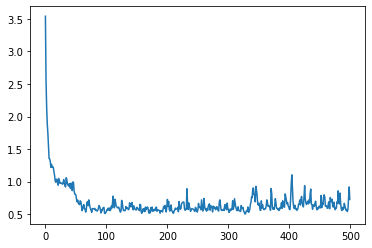

In [10]:
plt.plot(reproduction_losses)


In [90]:
with torch.no_grad():
    noise = torch.randn(vae_batch_size, latent_dim).to(device)
    generated_images =  model.Decoder(noise)

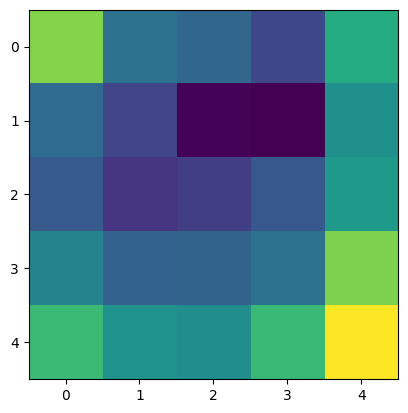

In [91]:
plt.imshow(generated_images[0].view(8, 5, 5).detach().cpu()[0])

In [92]:
vmin, vmax = -2.5, 2.5

In [93]:
def visualise_vae_joint(num_rows, generated_images):
  _, axarr = plt.subplots(num_rows, num_filters, figsize=(int(5*(num_filters//8)), num_rows))

  x = generated_images
  x = x.view(vae_batch_size, 8, 5, 5)

  for i in range(num_rows):
    idx = random.choice(range(len(generated_images)))
    for j in range(num_filters):
      axarr[i, j].set_axis_off()
      axarr[i, j].imshow(x[idx][j].cpu().numpy(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))

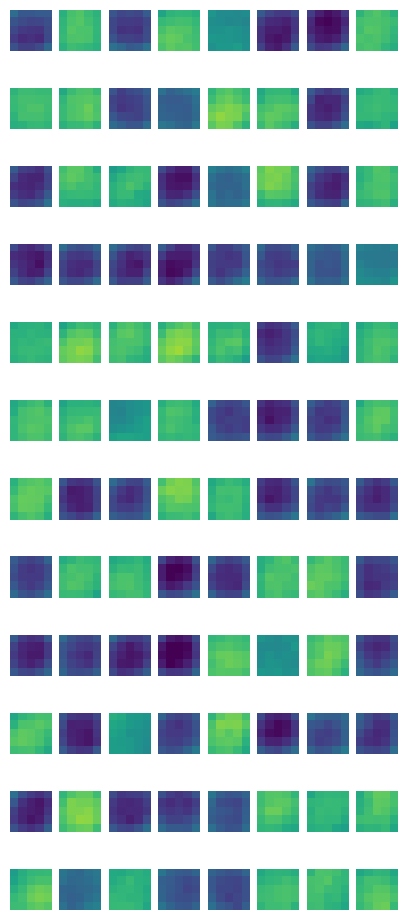

In [94]:
visualise_vae_joint(100//num_filters, generated_images)

In [ ]:
for i in range(len(dataset)):
    print(i, "\n", torch.max(dataset[i]), "\n", torch.min(dataset[i]), "\n\n")

In [155]:
k = 33
print(torch.mean(dataset[100*k:100*(k+1)]))
print(torch.std(dataset[100*k:100*(k+1)]))

tensor(-0.1181, device='cuda:0')
tensor(1.3148, device='cuda:0')


In [136]:
def debug(x):
    for i in range(len(x)):
        print(i, "\n", torch.max(x[i]), "\n", torch.min(x[i]), "\n\n")

In [ ]:
debug(generated_images)